### Mosaicking Hubble Data
Going to follow the normal way I do this. Hopefully, with mega deep imaging, this works well...

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

from astroquery.mast import Observations
from astropy.coordinates import SkyCoord
import astropy.units as u

from astropy.io import fits
from astropy import wcs
from astropy.nddata import Cutout2D, block_reduce
from astropy.table import Table, join
from astropy.visualization import ZScaleInterval, LinearStretch, ImageNormalize, AsinhStretch

from reproject.mosaicking import find_optimal_celestial_wcs, reproject_and_coadd
from reproject import reproject_interp

In [5]:
df = pd.read_csv('C:/Users/oryan/Documents/zoobot_new/manifests/gz-mergers-coords.csv',index_col=0)

In [6]:
test_row = df.iloc[0]
ra = test_row['Prim_RA']
dec = test_row['Prim_DEC']
#mission = test_row['imaging']

In [7]:
test_row

Prim_RA       204.97
Prim_DEC    0.839844
Names         Arp240
Sec_RA        204.99
Sec_DEC     0.830667
Name: 0, dtype: object

In [8]:
coord = SkyCoord(ra = ra * u.deg, dec = dec * u.deg, frame = 'fk5')
coord_2 = SkyCoord(ra = test_row['Sec_RA'] * u.deg, dec = test_row['Sec_DEC'] * u.deg, frame = 'fk5')

In [17]:
obs_table = Observations.query_region(coord,radius=0.05 * u.deg, obs_collection = '')

In [18]:
mask = (obs_table['instrument_name'] == 'ACS/WFC')
obs_wfc = obs_table[mask]

In [21]:
obs_wfc['filters']

F435W
F814W
detection
CLEAR1L;F435W
CLEAR1L;F814W
F435W
F814W
F814W;F435W
DETECTION
F435W
F814W


In [22]:
filters_download = ['F435W','F814W']

In [23]:
obs_id = list(obs_wfc['obs_id'])

In [26]:
queried_obs = Observations.query_criteria(obs_id=obs_id, filters=filters_download,obs_collection = ['HST', 'HLA'])

In [106]:
from astroquery.esasky import ESASky
import glob
import os
import matplotlib.pyplot as plt

In [78]:
result = ESASky.query_region_maps(
    position = coord, 
    radius= 1 * u.deg, 
    missions = ['HST-OPTICAL'], 
    cache=True
)

In [79]:
obs_table = result[0]

In [126]:
obs_table

collection,dec_deg,end_time,exposure_duration,filter,fov,instrument_name,npix,observation_id,observation_oid,obs_type,postcard_url,product_url,ra_deg,start_time,stc_s,target_name
,deg,time,seconds,,,,,,,,,,deg,time,,
object,float64,object,float64,object,object,object,int64,object,object,object,object,object,float64,object,object,object
HLA,0.09729397832493827,1998-04-09 20:06:13.94,2300.0,F850LP,"{(3.58832383025798 , 0.00178074198251729),(3.58849618152161 , 0.00178777565940283),(3.58850248216021 , 0.00161566874186367),(3.58833037524267 , 0.00160814637278758)}",WFPC2,416363,hst_07505_z1_wfpc2_f850lp_pc,hst_07505_z1_wfpc2_f850lp_pc,HLA Visit Association,https://hst.esac.esa.int/ehst-sl-server/servlet/data-action?OBSERVATION_ID=hst_07505_z1_wfpc2_f850lp_pc&RETRIEVAL_TYPE=POSTCARD,https://hst.esac.esa.int/ehst-sl-server/servlet/data-action?RETRIEVAL_TYPE=SCIENCE_PRODUCT&OBSERVATION_ID=hst_07505_z1_wfpc2_f850lp_pc,205.60093008239792,1998-04-09 19:25:13.95,POLYGON J2000 205.595810999999998 0.102028999999999995 205.605685999999992 0.102431999999999995 205.60604699999999 0.0925710000000000005 205.596185999999989 0.0921399999999999997,SN1998F
HLA,0.1040581557183585,1998-04-09 20:06:13.94,2300.0,F850LP,"{(3.58812816139553 , 0.00175487620300274),(3.58811215672629 , 0.00213254799984179),(3.58883016772727 , 0.00216066525409142),(3.58885683635824 , 0.00143151905248575),(3.58847965325359 , 0.00141987770637495)}",WFPC2,416363,hst_07505_z1_wfpc2_f850lp_wf,hst_07505_z1_wfpc2_f850lp_wf,HLA Visit Association,https://hst.esac.esa.int/ehst-sl-server/servlet/data-action?OBSERVATION_ID=hst_07505_z1_wfpc2_f850lp_wf&RETRIEVAL_TYPE=POSTCARD,https://hst.esac.esa.int/ehst-sl-server/servlet/data-action?RETRIEVAL_TYPE=SCIENCE_PRODUCT&OBSERVATION_ID=hst_07505_z1_wfpc2_f850lp_wf,205.6068022602766,1998-04-09 19:25:13.95,POLYGON J2000 205.584599999999995 0.100546999999999997 205.583683000000008 0.122186000000000003 205.624821999999995 0.123797000000000004 205.626350000000002 0.0820199999999999957 205.604738999999995 0.0813529999999999948,SN1998F
HLA,0.09729397832493827,1998-04-09 20:06:13.94,2300.0,F850LP,"{(3.58832383025798 , 0.00178074198251729),(3.58849618152161 , 0.00178777565940283),(3.58850248216021 , 0.00161566874186367),(3.58833037524267 , 0.00160814637278758)}",WFPC2,416363,hst_07505_z1_wfpc2_total_pc,hst_07505_z1_wfpc2_total_pc,HLA Visit Association,https://hst.esac.esa.int/ehst-sl-server/servlet/data-action?OBSERVATION_ID=hst_07505_z1_wfpc2_total_pc&RETRIEVAL_TYPE=POSTCARD,https://hst.esac.esa.int/ehst-sl-server/servlet/data-action?RETRIEVAL_TYPE=SCIENCE_PRODUCT&OBSERVATION_ID=hst_07505_z1_wfpc2_total_pc,205.60093008239792,1998-04-09 19:25:13.95,POLYGON J2000 205.595810999999998 0.102028999999999995 205.605685999999992 0.102431999999999995 205.60604699999999 0.0925710000000000005 205.596185999999989 0.0921399999999999997,SN1998F
HLA,0.1040581557183585,1998-04-09 20:06:13.94,2300.0,F850LP,"{(3.58812816139553 , 0.00175487620300274),(3.58811215672629 , 0.00213254799984179),(3.58883016772727 , 0.00216066525409142),(3.58885683635824 , 0.00143151905248575),(3.58847965325359 , 0.00141987770637495)}",WFPC2,416363,hst_07505_z1_wfpc2_total_wf,hst_07505_z1_wfpc2_total_wf,HLA Visit Association,https://hst.esac.esa.int/ehst-sl-server/servlet/data-action?OBSERVATION_ID=hst_07505_z1_wfpc2_total_wf&RETRIEVAL_TYPE=POSTCARD,https://hst.esac.esa.int/ehst-sl-server/servlet/data-action?RETRIEVAL_TYPE=SCIENCE_PRODUCT&OBSERVATION_ID=hst_07505_z1_wfpc2_total_wf,205.6068022602766,1998-04-09 19:25:13.95,POLYGON J2000 205.584599999999995 0.100546999999999997 205.583683000000008 0.122186000000000003 205.624821999999995 0.123797000000000004 205.626350000000002 0.0820199999999999957 205.604738999999995 0.0813529999999999948,SN1998F
HLA,0.8318577860218517,2001-07-06 19:06:54.87,80.0,F814W,"{(3.57765702364161 , 0.0145663434042195),(3.57781679108134 , 0.014631548905074),(3.57788176968939 , 0.0144703502953598),(3.57772224659576 , 0.0144061047255939)}",WFPC2,416459,hst_09124_62_wfpc2_

In [93]:
mask = (obs_table['instrument_name'].astype(str) == 'ACS/WFC') & (obs_table['filter'].astype(str) == 'F814W')

In [94]:
obs_table[mask]

collection,dec_deg,end_time,exposure_duration,filter,fov,instrument_name,npix,observation_id,observation_oid,obs_type,postcard_url,product_url,ra_deg,start_time,stc_s,target_name
,deg,time,seconds,,,,,,,,,,deg,time,,
object,float64,object,float64,object,object,object,int64,object,object,object,object,object,float64,object,object,object
HST,0.8385285869152127,2005-12-21 01:45:53.61,720.0,F814W,"{(3.57707613879664 , 0.0151406225270384),(3.5780682996588 , 0.015117019741432),(3.57809757458994 , 0.0141130423021013),(3.57712955442386 , 0.0141614627970065)}",ACS/WFC,416459,hst_10592_49_acs_wfc_f814w_j9cv49,hst_10592_49_acs_wfc_f814w_j9cv49,HAP Composite,https://hst.esac.esa.int/ehst-sl-server/servlet/data-action?OBSERVATION_ID=hst_10592_49_acs_wfc_f814w_j9cv49&RETRIEVAL_TYPE=POSTCARD,https://hst.esac.esa.int/ehst-sl-server/servlet/data-action?RETRIEVAL_TYPE=SCIENCE_PRODUCT&OBSERVATION_ID=hst_10592_49_acs_wfc_f814w_j9cv49,204.9810899377636,2005-12-21 01:31:12.56,POLYGON J2000 204.951365750000008 0.867493770000000053 205.008212380000003 0.86614142999999999 205.00988971000001 0.808617759999999963 204.954426240000004 0.811392050000000031,NGC5257


In [95]:
hdul = fits.open('eHst7591677/HST/hst_10592_49_acs_wfc_f814w_j9cv49/hst_10592_49_acs_wfc_f814w_j9cv49_drc.fits')

In [111]:
hdul[1].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 5772                                                  
NAXIS2  =                 5713                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
INHERIT =                    T / inherit the primary header                     
EXTNAME = 'SCI     '           / extension name                                 
EXTVER  =                    1                                                  
BUNIT   = 'ELECTRONS/S'        / Units of science product                       
                                                                                
              / WFC CCD CHIP

In [105]:
data = hdul[1].data

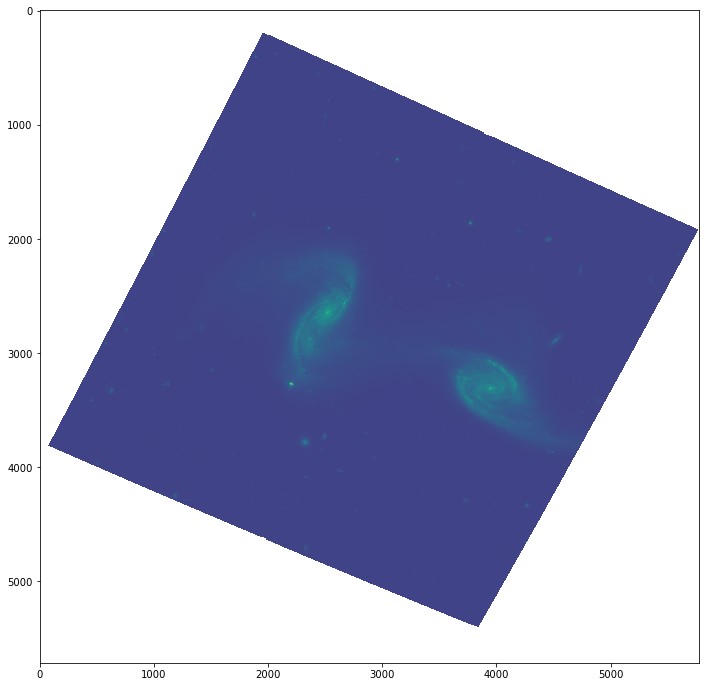

In [109]:
plt.figure(figsize=(12,12))
plt.imshow(np.log10(data))

In [74]:
files = glob.glob('Maps/HST-OPTICAL/*.fits.gz')
regions = []
for i in files:
    if 'f814w' in i and 'acs_wfc' in i:
        regions.append(i)

In [75]:
regions

['Maps/HST-OPTICAL\\hst_10592_49_acs_wfc_f814w_drz.fits.gz',
 'Maps/HST-OPTICAL\\hst_mos_0030267_acs_wfc_f814w_drz.fits.gz']

In [59]:
hdu_list = []
for i in regions:
    hdul = fits.open(i)
    hdu_list.append(hdul[1])

In [60]:
wcs_out, shape_out = find_optimal_celestial_wcs(hdu_list)

In [62]:
array,footprint = reproject_and_coadd(hdu_list, output_projection = wcs_out, shape_out = shape_out, reproject_function = reproject_interp)

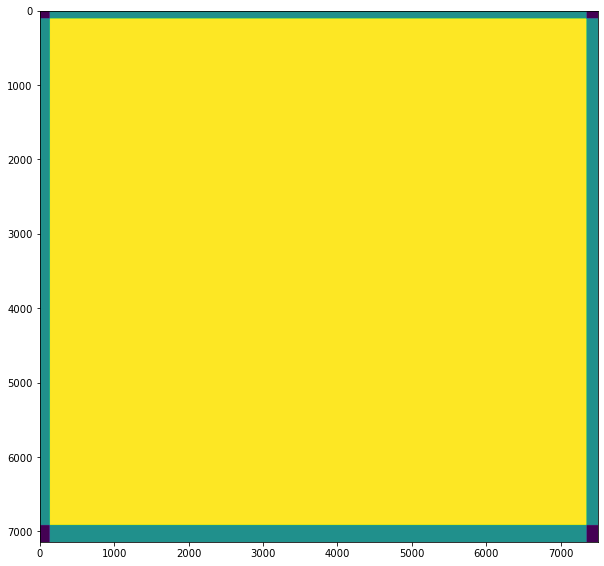

In [63]:
plt.figure(figsize=(10,10))
plt.imshow(footprint)

C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


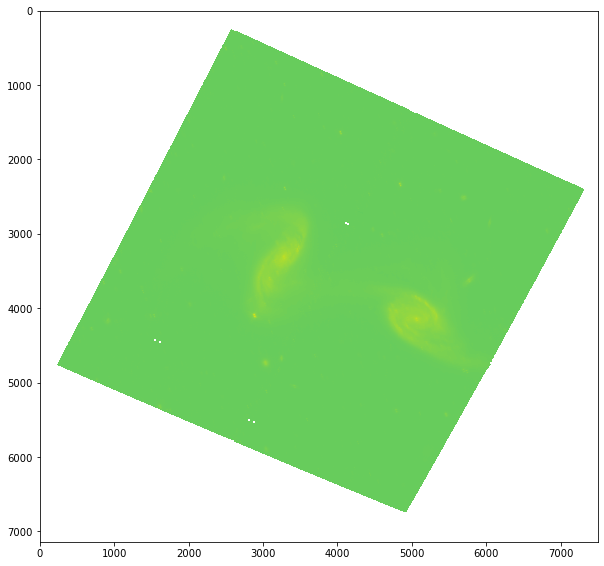

In [67]:
plt.figure(figsize=(10,10))
plt.imshow(np.log10(array))